In [4]:
import sys
import numpy as np
import pandas as pd
import os
from dataclasses import dataclass
from typing import Dict, List, Tuple, Callable

from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt

In [5]:
# -------------------------------------------------
# 0. Global configuration
# -------------------------------------------------

INTERSECTIONS = ["D-42", "D-38"]

CYCLE_LENGTH = 60.0   
SERVICE_RATE = 0.8       
GREEN_MIN = 0.2        
GREEN_MAX = 0.8       
GREEN_ACTIONS = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])  # expand 

DISCOUNT_GAMMA = 0.9     

ALPHA_OES = 1.0
BETA_OES = 0.015
GAMMA_OES = 1.0

In [6]:

def load_volume_data(
    volume_csv_path: str,
    intersections: List[str] = INTERSECTIONS
) -> pd.DataFrame:
    df = pd.read_csv(volume_csv_path)

    ts_col_candidates = [c for c in df.columns if "time" in c.lower() or "datetime" in c.lower()]
    assert len(ts_col_candidates) >= 1, "Timestamp column not found in volume csv."
    ts_col = ts_col_candidates[0]

    df[ts_col] = pd.to_datetime(df[ts_col])

    df = df[df["point_id"].isin(intersections)].copy()

    pivot = df.pivot_table(
        index=ts_col,
        columns="point_id",
        values="traffic_volume"
    ).sort_index()

    pivot = pivot.reindex(
        pd.date_range(start=pivot.index.min(),
                      end=pivot.index.max(),
                      freq="H")
    )
    pivot = pivot.interpolate().ffill().bfill()

    pivot = pivot[intersections]

    return pivot


def volume_to_arrival_rate(volume: float) -> float:
    return volume / 3600.0


In [7]:
@dataclass
class MultiIntersectionState:
    queues: np.ndarray      # shape (n_intersections,)
    arrivals: np.ndarray    # shape (n_intersections,)
    neighbor_pressures: np.ndarray  # shape (n_intersections,)


class QueueEnv:
    def __init__(
        self,
        arrival_df: pd.DataFrame,
        cycle_length: float = CYCLE_LENGTH,
        service_rate: float = SERVICE_RATE,
        green_min: float = GREEN_MIN,
        green_max: float = GREEN_MAX,
        green_actions: np.ndarray = GREEN_ACTIONS
    ):
        self.arrival_df = arrival_df
        self.timestamps = arrival_df.index
        self.n_steps = len(self.timestamps)
        self.intersections = list(arrival_df.columns)
        self.n_agents = len(self.intersections)

        self.C = cycle_length
        self.s = service_rate
        self.green_min = green_min
        self.green_max = green_max
        self.green_actions = green_actions

        self.t = 0
        self.queues = np.zeros(self.n_agents, dtype=float)

    def reset(self, noise_std: float = 0.05) -> MultiIntersectionState:
        self.t = 0
        self.queues = np.zeros(self.n_agents, dtype=float)
        return self._build_state(noise_std=noise_std)

    def _get_arrivals(self, t: int, noise_std: float = 0.05) -> np.ndarray:
        t = max(0, min(t, self.n_steps - 1))

        base_volumes = self.arrival_df.iloc[t].values  # veh/hour
        lam = np.array([volume_to_arrival_rate(v) for v in base_volumes])  # veh/sec
        if noise_std > 0:
            lam = np.maximum(
                lam + np.random.randn(*lam.shape) * lam * noise_std,
                0.0
            )
        return lam

    def _build_state(self, noise_std: float = 0.05) -> MultiIntersectionState:
        lam = self._get_arrivals(self.t, noise_std=noise_std)
        neighbor_pressures = []
        for i in range(self.n_agents):
            neighbor_pressures.append(np.sum(self.queues) - self.queues[i])
        neighbor_pressures = np.array(neighbor_pressures)
        return MultiIntersectionState(
            queues=self.queues.copy(),
            arrivals=lam,
            neighbor_pressures=neighbor_pressures
        )

    def step(
        self,
        green_actions_idx: np.ndarray,
        noise_std: float = 0.05
    ) -> Tuple[MultiIntersectionState, np.ndarray, Dict]:

        assert len(green_actions_idx) == self.n_agents

        lam = self._get_arrivals(self.t, noise_std=noise_std)

        g = self.green_actions[green_actions_idx]
        g = np.clip(g, self.green_min, self.green_max)

        capacity = self.s * g * self.C  # veh per cycle that can be served
        queue_before = self.queues.copy()

        arrivals_veh = lam * self.C

        served = np.minimum(queue_before + arrivals_veh, capacity)
        queue_after = np.maximum(queue_before + arrivals_veh - served, 0.0)

        backlog_old = np.maximum(queue_before - capacity, 0.0)
        new_waiters = np.maximum(queue_after - backlog_old, 0.0)

        throughput = served
        wait_time_total = queue_before * self.C   # veh * sec per cycle
        stops = new_waiters                       # count vehicles that had to stop

        awt_instant = np.where(
            throughput > 0,
            wait_time_total / (throughput + 1e-6),
            queue_before * self.C  # fallback if no throughput
        )
        ans_instant = np.where(
            throughput > 0,
            stops / (throughput + 1e-6),
            stops  # fallback
        )

        # OES = -α*AWT + β*TP - γ*ANS
        oes_reward = (
            -ALPHA_OES * awt_instant +
            BETA_OES * throughput -
            GAMMA_OES * ans_instant
        )

        rewards = oes_reward

        self.queues = queue_after
        self.t += 1
        done = self.t >= min(self.n_steps, getattr(self, "max_steps", self.n_steps))

        if done:
            lam_next = np.zeros_like(lam)
            neighbor_pressures = []
            for i in range(self.n_agents):
                neighbor_pressures.append(np.sum(self.queues) - self.queues[i])
            neighbor_pressures = np.array(neighbor_pressures)
            next_state = MultiIntersectionState(
                queues=self.queues.copy(),
                arrivals=lam_next,
                neighbor_pressures=neighbor_pressures
            )
        else:
            next_state = self._build_state(noise_std=noise_std)

        info = {
            "throughput": throughput,
            "wait_time": wait_time_total,
            "stops": stops,
            "queue_before": queue_before,
            "queue_after": queue_after,
        }
        return next_state, rewards, done, info

In [8]:
def compute_fixed_green_splits(env: QueueEnv) -> np.ndarray:
    avg_volume = env.arrival_df.mean(axis=0).values  # veh/hour per intersection
    avg_lambda = np.array([volume_to_arrival_rate(v) for v in avg_volume])  # veh/sec
    g = np.clip(avg_lambda / env.s, env.green_min, env.green_max)
    idxs = np.argmin(np.abs(env.green_actions[None, :] - g[:, None]), axis=1)
    return idxs.astype(int)


def fixed_time_policy(env: QueueEnv) -> Callable[[MultiIntersectionState], np.ndarray]:
    fixed_idxs = compute_fixed_green_splits(env)

    def policy_fn(state: MultiIntersectionState) -> np.ndarray:
        return fixed_idxs

    return policy_fn


def responsive_policy(env: QueueEnv, smoothing: float = 0.3) -> Callable[[MultiIntersectionState], np.ndarray]:
    lam_smooth = np.zeros(env.n_agents, dtype=float)

    def policy_fn(state: MultiIntersectionState) -> np.ndarray:
        nonlocal lam_smooth
        lam_obs = state.arrivals
        lam_smooth = (1 - smoothing) * lam_smooth + smoothing * lam_obs
        g = np.clip(lam_smooth / env.s, env.green_min, env.green_max)
        idxs = np.argmin(np.abs(env.green_actions[None, :] - g[:, None]), axis=1)
        return idxs.astype(int)

    return policy_fn


In [9]:
class TabularQLearningController:
    def __init__(
        self,
        env: QueueEnv,
        n_queue_bins: int = 10,
        n_arrival_bins: int = 5,
        alpha: float = 0.1,
        gamma: float = DISCOUNT_GAMMA,
        eps_start: float = 1.0,
        eps_end: float = 0.05,
        eps_decay_steps: int = 5000
    ):
        self.env = env
        self.n_agents = env.n_agents
        self.n_actions = len(env.green_actions)

        self.n_queue_bins = n_queue_bins
        self.n_arrival_bins = n_arrival_bins

        self.alpha = alpha
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay_steps = eps_decay_steps
        self.total_steps = 0

        n_states = n_queue_bins * n_arrival_bins
        self.Q = np.zeros((self.n_agents, n_states, self.n_actions), dtype=float)

    def _discretize_state_one(self, q: float, lam: float) -> int:
        q_max = 80.0     # vehicles
        lam_max = 0.8    # veh/sec (~2880 veh/h)

        q_bin = int(np.clip(q / q_max * self.n_queue_bins, 0, self.n_queue_bins - 1))
        lam_bin = int(np.clip(lam / lam_max * self.n_arrival_bins, 0, self.n_arrival_bins - 1))
        return q_bin * self.n_arrival_bins + lam_bin

    def _discretize_state(self, state: MultiIntersectionState) -> np.ndarray:
        idxs = []
        for i in range(self.n_agents):
            idxs.append(self._discretize_state_one(state.queues[i], state.arrivals[i]))
        return np.array(idxs, dtype=int)

    def _epsilon(self) -> float:
        if self.total_steps >= self.eps_decay_steps:
            return self.eps_end
        frac = self.total_steps / self.eps_decay_steps
        return self.eps_start + frac * (self.eps_end - self.eps_start)

    def train(self, n_episodes: int = 150, noise_std: float = 0.05):
        for ep in range(n_episodes):
            state = self.env.reset(noise_std=noise_std)
            done = False
            while not done:
                self.total_steps += 1
                s_idx = self._discretize_state(state)
                eps = self._epsilon()

                actions = np.zeros(self.n_agents, dtype=int)
                for i in range(self.n_agents):
                    if np.random.rand() < eps:
                        actions[i] = np.random.randint(self.n_actions)
                    else:
                        actions[i] = np.argmax(self.Q[i, s_idx[i]])

                next_state, rewards, done, _ = self.env.step(actions, noise_std=noise_std)
                s_next_idx = self._discretize_state(next_state)

                for i in range(self.n_agents):
                    a = actions[i]
                    target = rewards[i] + self.gamma * np.max(self.Q[i, s_next_idx[i]])
                    self.Q[i, s_idx[i], a] += self.alpha * (target - self.Q[i, s_idx[i], a])

                state = next_state

    def greedy_policy(self) -> Callable[[MultiIntersectionState], np.ndarray]:
        def policy_fn(state: MultiIntersectionState) -> np.ndarray:
            s_idx = self._discretize_state(state)
            actions = np.zeros(self.n_agents, dtype=int)
            for i in range(self.n_agents):
                actions[i] = int(np.argmax(self.Q[i, s_idx[i]]))
            return actions
        return policy_fn

In [10]:
def generate_offline_dataset(
    env: QueueEnv,
    behavior_policy: Callable[[MultiIntersectionState], np.ndarray],
    n_rollouts: int = 50,
    noise_std: float = 0.05
) -> Dict[str, pd.DataFrame]:
    
    n_agents = env.n_agents
    agent_ids = env.intersections

    data_per_agent = {aid: [] for aid in agent_ids}

    for k in range(n_rollouts):
        state = env.reset(noise_std=noise_std)
        done = False
        while not done:
            actions = behavior_policy(state)
            next_state, rewards, done, info = env.step(actions, noise_std=noise_std)

            for i, aid in enumerate(agent_ids):
                s_vec = np.array([
                    state.queues[i],
                    state.arrivals[i],
                    state.neighbor_pressures[i]
                ])
                s_next_vec = np.array([
                    next_state.queues[i],
                    next_state.arrivals[i],
                    next_state.neighbor_pressures[i]
                ])
                data_per_agent[aid].append({
                    "q": s_vec[0],
                    "lam": s_vec[1],
                    "neigh": s_vec[2],
                    "action_idx": int(actions[i]),
                    "reward": float(rewards[i]),
                    "q_next": s_next_vec[0],
                    "lam_next": s_next_vec[1],
                    "neigh_next": s_next_vec[2],
                })

            state = next_state

    for aid in agent_ids:
        data_per_agent[aid] = pd.DataFrame(data_per_agent[aid])

    return data_per_agent


In [11]:
class STFQI_Agent:
    def __init__(
        self,
        tau_support: float = 0.05,
        gamma: float = DISCOUNT_GAMMA,
        n_iters: int = 15,
        early_stop_threshold: float = 0.05,
        target_clip: float = 4.0,
        conservative_alpha: float = 0.1
    ):
        self.tau = tau_support
        self.gamma = gamma
        self.n_iters = n_iters
        self.early_stop_threshold = early_stop_threshold
        self.target_clip = target_clip
        self.conservative_alpha = conservative_alpha

        self.behavior_clf = RandomForestClassifier(
            n_estimators=100,
            max_depth=15,
            min_samples_leaf=5,
            min_samples_split=10,
            n_jobs=-1,
            random_state=42
        )
        self.q_reg = ExtraTreesRegressor(
            n_estimators=150,
            max_depth=15,
            min_samples_leaf=5,
            min_samples_split=10,
            n_jobs=-1,
            random_state=42
        )
        self.is_fitted = False

        self.reward_mean = 0.0
        self.reward_std = 1.0
        self.n_actions = None  # Will be set during training

    @staticmethod
    def _build_features_state(s: np.ndarray) -> np.ndarray:
        q = s[:, 0:1]
        lam = s[:, 1:2]
        neigh = s[:, 2:3]
        
        q_sq = q ** 2
        lam_sq = lam ** 2
        neigh_sq = neigh ** 2
        
        q_lam = q * lam
        q_neigh = q * neigh
        lam_neigh = lam * neigh
        
        return np.concatenate([
            s,
            q_sq, lam_sq, neigh_sq,
            q_lam, q_neigh, lam_neigh
        ], axis=1)

    @staticmethod
    def _build_features_state_action(s: np.ndarray, a_idx: np.ndarray, n_actions: int) -> np.ndarray:
        N = s.shape[0]
        a_onehot = np.zeros((N, n_actions), dtype=float)
        a_onehot[np.arange(N), a_idx] = 1.0
        
        state_features = STFQI_Agent._build_features_state(s)
        
        return np.concatenate([state_features, a_onehot], axis=1)

    def fit_behavior_model(self, s_arr: np.ndarray, a_arr: np.ndarray, n_actions: int):
        X = self._build_features_state(s_arr)
        y = a_arr
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
        self.behavior_clf.fit(X_train, y_train)
        y_val_proba = self.behavior_clf.predict_proba(X_val)
        
        all_labels = np.arange(n_actions)
        ll = log_loss(y_val, y_val_proba, labels=all_labels)
        print(f"    [ST-FQI] Behavior classifier log-loss: {ll:.3f}")

        train_acc = self.behavior_clf.score(X_train, y_train)
        val_acc = self.behavior_clf.score(X_val, y_val)
        print(f"    [ST-FQI] Behavior classifier train acc: {train_acc:.3f}, val acc: {val_acc:.3f}")

    def _support_actions(self, s: np.ndarray) -> np.ndarray:
        proba = self.behavior_clf.predict_proba(self._build_features_state(s))
        n_actions = proba.shape[1]
        support_mask = proba >= self.tau
        return support_mask, proba

    def fit_fqi(self, dataset: pd.DataFrame, n_actions: int):
        self.n_actions = n_actions
        
        s = dataset[["q", "lam", "neigh"]].values.astype(float)
        a = dataset["action_idx"].values.astype(int)
        r = dataset["reward"].values.astype(float)
        s_next = dataset[["q_next", "lam_next", "neigh_next"]].values.astype(float)

        print(f"    [ST-FQI] Dataset size: {len(dataset)} samples")
        print(f"    [ST-FQI] Reward stats (raw): mean={r.mean():.2f}, std={r.std():.2f}, min={r.min():.2f}, max={r.max():.2f}")

        self.reward_mean = r.mean()
        self.reward_std = r.std() + 1e-8
        r_normalized = (r - self.reward_mean) / self.reward_std
        print(f"    [ST-FQI] Reward normalized: mean={r_normalized.mean():.2f}, std={r_normalized.std():.2f}")

        self.fit_behavior_model(s, a, n_actions)

        N = s.shape[0]
        X_sa = self._build_features_state_action(s, a, n_actions)
        y = r_normalized.copy()
        self.q_reg.fit(X_sa, y)

        prev_avg_target = None
        for it in range(self.n_iters):
            support_mask, proba = self._support_actions(s_next)
            n_samples = s_next.shape[0]
            target = np.zeros(n_samples, dtype=float)

            all_q_vals = []
            for a_idx in range(n_actions):
                a_vec = np.full(n_samples, a_idx, dtype=int)
                X_next = self._build_features_state_action(s_next, a_vec, n_actions)
                q_vals = self.q_reg.predict(X_next)
                all_q_vals.append(q_vals)
            all_q_vals = np.stack(all_q_vals, axis=1)

            fallback_count = 0
            for i in range(n_samples):
                supported = np.where(support_mask[i])[0]
                if len(supported) > 0:
                    best_idx = supported[np.argmax(all_q_vals[i, supported])]
                else:
                    best_idx = int(np.argmax(proba[i]))
                    fallback_count += 1
                
                max_q_next = all_q_vals[i, best_idx]
                max_q_next_clipped = np.clip(max_q_next, -self.target_clip, self.target_clip)
                
                target[i] = r_normalized[i] + self.gamma * max_q_next_clipped

            if self.conservative_alpha > 0:
                support_mask_current, proba_current = self._support_actions(s)
                for i in range(n_samples):
                    if proba_current[i, a[i]] < self.tau:
                        target[i] -= self.conservative_alpha

            X_sa = self._build_features_state_action(s, a, n_actions)
            self.q_reg.fit(X_sa, target)

            avg_target = target.mean()
            target_std = target.std()
            print(f"    [ST-FQI] Iter {it+1}/{self.n_iters}: avg_target={avg_target:.2f}, std={target_std:.2f}, fallback_rate={fallback_count/n_samples:.2%}")

            if prev_avg_target is not None:
                q_change = abs(avg_target - prev_avg_target)
                if q_change < self.early_stop_threshold:
                    print(f"    [ST-FQI] Early stopping at iter {it+1}: Q-value change {q_change:.2f} < {self.early_stop_threshold}")
                    break
            prev_avg_target = avg_target

        self.is_fitted = True

    def act_greedy(self, state: MultiIntersectionState, n_actions: int) -> int:
        assert self.is_fitted
        s = np.array([[state.queues, state.arrivals, state.neighbor_pressures]])
        raise NotImplementedError("Use per-agent wrapper.")


class MultiAgentSTFQIController:
    def __init__(
        self, 
        env: QueueEnv, 
        tau_support: float = 0.05, 
        n_iters: int = 15,
        target_clip: float = 4.0,
        conservative_alpha: float = 0.1
    ):
        self.env = env
        self.n_agents = env.n_agents
        self.n_actions = len(env.green_actions)
        self.agents = [
            STFQI_Agent(
                tau_support=tau_support, 
                gamma=DISCOUNT_GAMMA, 
                n_iters=n_iters,
                target_clip=target_clip,
                conservative_alpha=conservative_alpha
            )
            for _ in range(self.n_agents)
        ]

    def train(self, datasets: Dict[str, pd.DataFrame]):
        for i, aid in enumerate(self.env.intersections):
            print(f"  === Training ST-FQI agent for intersection {aid} ===")
            self.agents[i].fit_fqi(datasets[aid], n_actions=self.n_actions)

    def policy(self) -> Callable[[MultiIntersectionState], np.ndarray]:
        def policy_fn(state: MultiIntersectionState) -> np.ndarray:
            actions = np.zeros(self.n_agents, dtype=int)
            for i in range(self.n_agents):
                s_vec = np.array([[state.queues[i],
                                   state.arrivals[i],
                                   state.neighbor_pressures[i]]])
                all_q = []
                support_mask, proba = self.agents[i]._support_actions(s_vec)
                support_mask = support_mask[0]
                proba = proba[0]
                for a_idx in range(self.n_actions):
                    sa_feat = STFQI_Agent._build_features_state_action(
                        s_vec, np.array([a_idx]), self.n_actions
                    )
                    q_val = self.agents[i].q_reg.predict(sa_feat)[0]
                    all_q.append(q_val)
                all_q = np.array(all_q)

                supported = np.where(support_mask)[0]
                if len(supported) > 0:
                    best_supported = supported[np.argmax(all_q[supported])]
                    actions[i] = int(best_supported)
                else:
                    actions[i] = int(np.argmax(proba))
            return actions
        return policy_fn

In [12]:
@dataclass
class EvalResult:
    algo_name: str
    awt: float
    tp: float
    ans: float
    oes: float


def evaluate_policy(
    env: QueueEnv,
    policy_fn: Callable[[MultiIntersectionState], np.ndarray],
    n_episodes: int = 10,
    noise_std: float = 0.05
) -> EvalResult:
    total_wait = 0.0
    total_tp = 0.0
    total_stops = 0.0
    total_departures = 0.0

    for ep in range(n_episodes):
        state = env.reset(noise_std=noise_std)
        done = False
        while not done:
            actions = policy_fn(state)
            next_state, rewards, done, info = env.step(actions, noise_std=noise_std)

            total_wait += np.sum(info["wait_time"])
            total_tp += np.sum(info["throughput"])
            total_stops += np.sum(info["stops"])
            total_departures += np.sum(info["throughput"])

            state = next_state

    if total_departures > 0:
        awt = total_wait / total_departures  # sec per vehicle
        ans = total_stops / total_departures
    else:
        awt = np.inf
        ans = np.inf

    tp = total_tp / n_episodes  # veh per episode

    oes = -ALPHA_OES * awt + BETA_OES * tp - GAMMA_OES * ans

    return EvalResult(algo_name="", awt=awt, tp=tp, ans=ans, oes=oes)

In [13]:
def diagnose_support_coverage(
    stfqi_controller: MultiAgentSTFQIController,
    env: QueueEnv,
    naive_policy: Callable[[MultiIntersectionState], np.ndarray],
    stfqi_policy: Callable[[MultiIntersectionState], np.ndarray],
    n_samples: int = 3000,
    noise_std: float = 0.05
) -> pd.DataFrame:
    n_agents = env.n_agents
    n_actions = len(env.green_actions)

    rows = []

    def collect(policy_name: str, use_support_gate: bool):
        state = env.reset(noise_std=noise_std)
        done = False
        while not done and len(rows) < n_samples:
            if use_support_gate:
                actions = stfqi_policy(state)
            else:
                actions = np.zeros(n_agents, dtype=int)
                for i in range(n_agents):
                    s_vec = np.array([[state.queues[i],
                                       state.arrivals[i],
                                       state.neighbor_pressures[i]]])
                    all_q = []
                    for a_idx in range(n_actions):
                        sa_feat = STFQI_Agent._build_features_state_action(
                            s_vec, np.array([a_idx]), n_actions
                        )
                        q_val = stfqi_controller.agents[i].q_reg.predict(sa_feat)[0]
                        all_q.append(q_val)
                    all_q = np.array(all_q)
                    actions[i] = int(np.argmax(all_q))

            for i in range(n_agents):
                s_vec = np.array([[state.queues[i],
                                   state.arrivals[i],
                                   state.neighbor_pressures[i]]])
                support_mask, proba = stfqi_controller.agents[i]._support_actions(s_vec)
                support_mask = support_mask[0]
                proba = proba[0]
                a = actions[i]
                behavior_p = proba[a]
                is_ood = behavior_p < stfqi_controller.agents[i].tau
                rows.append({
                    "policy": policy_name,
                    "agent": env.intersections[i],
                    "behavior_prob": behavior_p,
                    "is_ood": int(is_ood),
                })

            next_state, rewards, done, info = env.step(actions, noise_std=noise_std)
            state = next_state

    collect("Naive FQI", use_support_gate=False)
    collect("ST-FQI", use_support_gate=True)

    df = pd.DataFrame(rows)
    summary = df.groupby("policy").agg(
        avg_behavior_prob=("behavior_prob", "mean"),
        ood_rate=("is_ood", "mean"),
        n_samples=("is_ood", "count")
    ).reset_index()
    print(summary)
    return summary


In [14]:
def plot_results(results: List[EvalResult]):
    algos = [r.algo_name for r in results]
    awt = np.array([r.awt for r in results])
    tp = np.array([r.tp for r in results])
    ans = np.array([r.ans for r in results])
    oes = np.array([r.oes for r in results])

    # AWT
    plt.figure()
    plt.bar(algos, awt)
    plt.ylabel("AWT (sec/veh)")
    plt.title("Average Waiting Time by policy")
    plt.grid(axis="y", linestyle="--", alpha=0.4)

    # Throughput
    plt.figure()
    plt.bar(algos, tp)
    plt.ylabel("Throughput (veh/episode)")
    plt.title("Throughput by policy")
    plt.grid(axis="y", linestyle="--", alpha=0.4)

    # ANS
    plt.figure()
    plt.bar(algos, ans)
    plt.ylabel("ANS (stops/veh)")
    plt.title("Average Number of Stops by policy")
    plt.grid(axis="y", linestyle="--", alpha=0.4)

    # OES
    plt.figure()
    plt.bar(algos, oes)
    plt.ylabel("OES")
    plt.title("Overall Evaluation Score (OES)")
    plt.grid(axis="y", linestyle="--", alpha=0.4)


def plot_support_summary(summary_df: pd.DataFrame):
    policies = summary_df["policy"].tolist()
    ood = summary_df["ood_rate"].values
    beh = summary_df["avg_behavior_prob"].values

    x = np.arange(len(policies))
    width = 0.35

    plt.figure()
    plt.bar(x - width/2, ood, width, label="OOD action rate")
    plt.bar(x + width/2, beh, width, label="Avg behavior prob of π(s)")
    plt.xticks(x, policies)
    plt.ylabel("Rate / probability")
    plt.title("Support coverage diagnostics")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.4)



STARTING EVALUATION: tau=0.05, n_iters=15

Loading data from: /Users/chaewon/Desktop/reinforcement-learning/data/seoul_traffic_volume_2025_01_cleaned_en.csv


/var/folders/9q/j2d_c2m14qvdwsw8wnh46th80000gn/T/ipykernel_56042/2877917349.py:40: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.date_range(start=pivot.index.min(),


✓ Data loaded: 744 time steps, 2 intersections

Setting up baseline policies...
✓ Baseline policies ready

Training Q-learning baseline...
✓ Q-learning training complete

Generating offline dataset...
Dataset sizes:
  ✓ Agent D-42: 74,400 samples
  ✓ Agent D-38: 74,400 samples

Training ST-FQI with tau=0.05, n_iters=15
Hyperparameters:
  tau = 0.05
  n_iters = 15
  target_clip = 4.0
  conservative_alpha = 0.05

  === Training ST-FQI agent for intersection D-42 ===
    [ST-FQI] Dataset size: 74400 samples
    [ST-FQI] Reward stats (raw): mean=-142.44, std=111.77, min=-1157.48, max=0.42
    [ST-FQI] Reward normalized: mean=0.00, std=1.00
    [ST-FQI] Behavior classifier log-loss: 0.770
    [ST-FQI] Behavior classifier train acc: 0.780, val acc: 0.653
    [ST-FQI] Iter 1/15: avg_target=0.16, std=1.73, fallback_rate=0.00%
    [ST-FQI] Iter 2/15: avg_target=0.37, std=2.29, fallback_rate=0.00%
    [ST-FQI] Iter 3/15: avg_target=0.63, std=2.73, fallback_rate=0.00%
    [ST-FQI] Iter 4/15: avg_

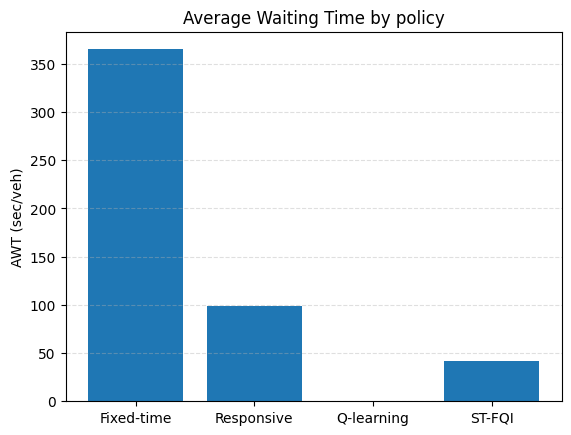

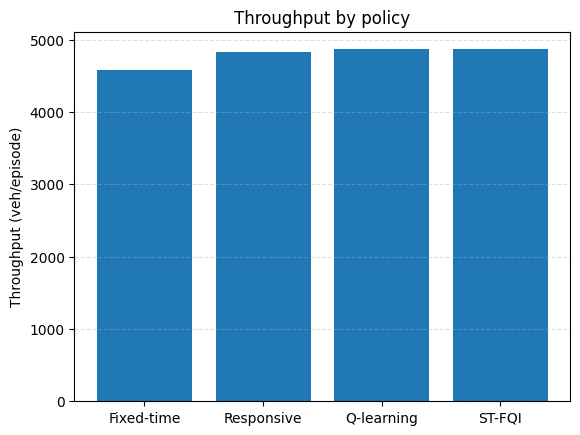

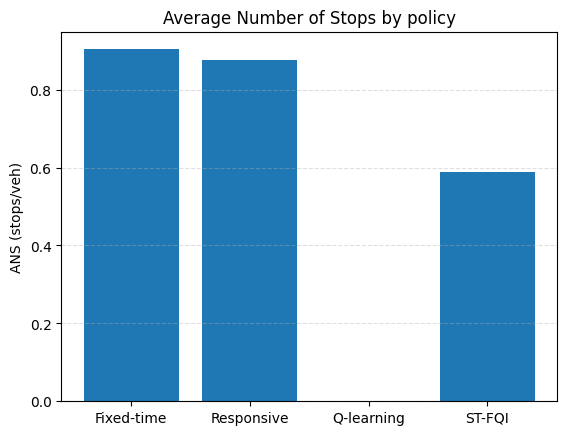

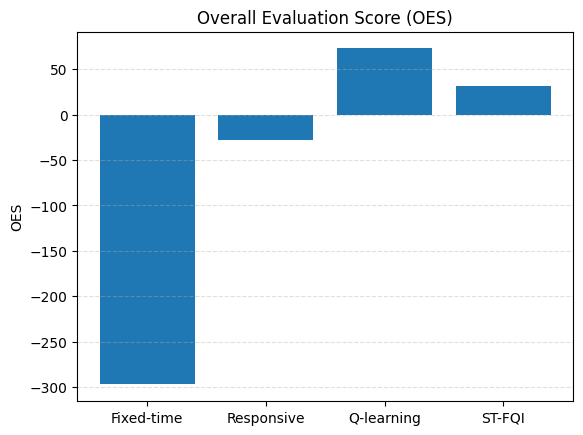

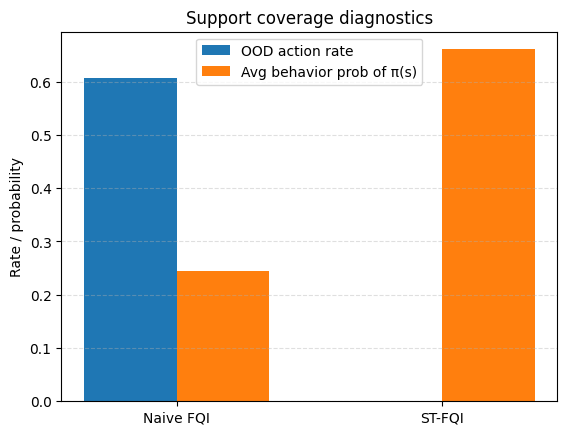

ALL DONE!


In [16]:
def quick_main():
    volume_csv_path = "./data/seoul_traffic_volume_2025_01_cleaned_en.csv"

    arrival_df = load_volume_data(volume_csv_path, INTERSECTIONS)
    env_for_data = QueueEnv(arrival_df)

    print("Setting up baseline policies...")
    fixed_policy_fn = fixed_time_policy(env_for_data)
    responsive_policy_fn = responsive_policy(env_for_data, smoothing=0.3)
    print("Baseline policies ready\n")

    print("Training Q-learning baseline...")
    q_env = QueueEnv(arrival_df)
    q_controller = TabularQLearningController(q_env, eps_decay_steps=8000)
    q_controller.train(n_episodes=150)
    q_policy_fn = q_controller.greedy_policy()
    print("Q-learning training complete\n")

    behavior_env = QueueEnv(arrival_df)
    behavior_policy_fn = responsive_policy(behavior_env, smoothing=0.3)
    datasets = generate_offline_dataset(
        behavior_env, behavior_policy_fn, n_rollouts=100, noise_std=0.08
    )

    print("Training ST-FQI...")

    BEST_TAU = 0.05
    BEST_N_ITERS = 15
    BEST_TARGET_CLIP = 4.0
    BEST_CONSERVATIVE_ALPHA = 0.05

    st_env = QueueEnv(arrival_df)
    stfqi_controller = MultiAgentSTFQIController(
        st_env,
        tau_support=BEST_TAU,
        n_iters=BEST_N_ITERS,
        target_clip=BEST_TARGET_CLIP,
        conservative_alpha=BEST_CONSERVATIVE_ALPHA
    )

    stfqi_controller.train(datasets)
    st_policy_fn = stfqi_controller.policy()
    print("ST-FQI training complete\n")

    eval_env = QueueEnv(arrival_df)
    eval_env.max_steps = 150

    res_fixed = evaluate_policy(eval_env, fixed_policy_fn, n_episodes=30, noise_std=0.08)
    res_fixed.algo_name = "Fixed-time"

    res_resp = evaluate_policy(eval_env, responsive_policy_fn, n_episodes=30, noise_std=0.08)
    res_resp.algo_name = "Responsive"

    print("Evaluating Q-learning policy...")
    eval_env_q = QueueEnv(arrival_df)
    eval_env_q.max_steps = 150
    res_q = evaluate_policy(eval_env_q, q_policy_fn, n_episodes=30, noise_std=0.08)
    res_q.algo_name = "Q-learning"

    print("Evaluating ST-FQI policy...")
    eval_env_st = QueueEnv(arrival_df)
    eval_env_st.max_steps = 150
    res_st = evaluate_policy(eval_env_st, st_policy_fn, n_episodes=30, noise_std=0.08)
    res_st.algo_name = "ST-FQI"

    results = [res_fixed, res_resp, res_q, res_st]

    print(f"{'Algorithm':<15} {'AWT':<12} {'TP':<12} {'ANS':<12} {'OES':<12}")
    for r in results:
        print(f"{r.algo_name:<15} {r.awt:>10.2f}  {r.tp:>10.1f}  {r.ans:>10.3f}  {r.oes:>10.2f}")

    best_algo = max(results, key=lambda x: x.oes)
    print(f"\nBest Algorithm: {best_algo.algo_name} with OES = {best_algo.oes:.2f}")

    st_fqi_result = next(r for r in results if r.algo_name == "ST-FQI")
    fixed_result = next(r for r in results if r.algo_name == "Fixed-time")

    awt_improvement = ((fixed_result.awt - st_fqi_result.awt) / fixed_result.awt) * 100
    tp_improvement = ((st_fqi_result.tp - fixed_result.tp) / fixed_result.tp) * 100
    oes_improvement = ((st_fqi_result.oes - fixed_result.oes) / abs(fixed_result.oes)) * 100

    print(f"\nST-FQI vs Fixed-time:")
    print(f"  AWT: {awt_improvement:+.1f}%")
    print(f"  TP:  {tp_improvement:+.1f}%")
    print(f"  OES: {oes_improvement:+.1f}%\n")

    print("Generating plots...")
    plot_results(results)
    print("Performance comparison plots generated\n")

    diag_env = QueueEnv(arrival_df)
    naive_vs_st_summary = diagnose_support_coverage(
        stfqi_controller, diag_env,
        naive_policy=None,
        stfqi_policy=st_policy_fn,
        n_samples=1500,
        noise_std=0.08
    )
    plot_support_summary(naive_vs_st_summary)
    plt.show()
    print("ALL DONE!")

    return results, stfqi_controller

results, stfqi_controller = quick_main()